In [1]:
# Import the generator
from h5imagegenerator import HDF5ImageGenerator

import numpy as np

# Some keras stuff
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler

# The image transformation pipeline (optional)
from albumentations import (
    Compose, ShiftScaleRotate
)

# Matplot
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')  
plt.style.use('seaborn-dark')
%matplotlib inline

Using TensorFlow backend.


In [2]:
# (Optional) Declare a transformation pipeline (data augmentation)
myAugmenter = Compose([
        ShiftScaleRotate(
            shift_limit=0.0225,
            scale_limit=0.06,
            rotate_limit=30)
    ])

# Instanciate a train generator
train_gen = HDF5ImageGenerator(
    src= '/storage/datasets/mnist_train.h5',
    num_classes=10,
    scaler=True,
    labels_encoding='smooth',
    smooth_factor=0.1,
    batch_size=128,
    augmenter=myAugmenter)

# Instanciate a test generator
val_gen = HDF5ImageGenerator(
    src= '/storage/datasets/mnist_test.h5',
    num_classes=10,
    scaler=True,
    labels_encoding='smooth',
    smooth_factor=0.1,
    batch_size=128)

### Network

In [3]:
from keras.models import Model
from keras import Input
from keras import layers

class CustomNet(object):
    @staticmethod
    def build(width, height, num_classes, depth=3):
        input_shape = (height, width, depth)
        chan_dim = -1

        input_tensor = Input(shape=input_shape)
        x = layers.SeparableConv2D(64,  (5, 5), padding='same', activation='relu')(input_tensor)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.SeparableConv2D(128, (5, 5), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.1)(x)

        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

        '''
        Flat the last output volume
        into a column vector
        '''
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)

        '''
        Add a final fully connected layer:
        There are as many neurons as there are outputs (10 -> [0..9])
        '''
        output_tensor = layers.Dense(num_classes, activation='softmax')(x)

        model = Model(input_tensor, output_tensor)

        return model

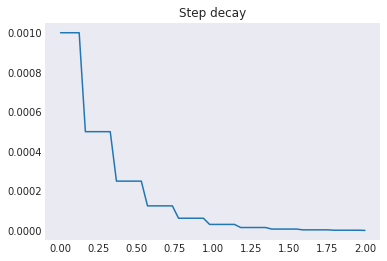

In [4]:
num_epochs = 2

init_lr = 0.001

def step_decay(epoch):
    factor    = 0.5
    drop_rate = 5

    return float(init_lr * (factor ** np.floor((1 + epoch) / drop_rate)))

x = np.linspace(0, num_epochs)
fx = [float(init_lr * (0.5 ** np.floor((1 + i) / 5))) for i in range(len(x))]
plt.plot(x, fx)
plt.title(label='Step decay')
plt.show()

In [5]:
!nvidia-smi

Sat Mar 14 12:51:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   30C    P0    27W / 105W |     88MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Training

In [6]:
model = CustomNet.build(
    width=28,
    height=28,
    num_classes=10,
    depth=1
)

rms = RMSprop(learning_rate=init_lr, rho=0.9)

callbacks = [
    LearningRateScheduler(step_decay)
]

model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=rms
)

h = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    callbacks=callbacks,
    workers=10,
    use_multiprocessing=True,
    verbose=1,
    epochs=num_epochs
)

Epoch 1/2
 53/469 [==>...........................] - ETA: 5:02 - loss: 0.8782 - accuracy: 0.8841

Process ForkPoolWorker-10:
Process ForkPoolWorker-3:
Process ForkPoolWorker-14:
Process ForkPoolWorker-16:
Process ForkPoolWorker-12:
Process ForkPoolWorker-19:
Process ForkPoolWorker-15:
Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-11:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Process ForkPoolWorker-13:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Process ForkPoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

KeyboardInterrupt: 

### Viz/Evaluate

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, num_epochs), h.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), h.history['val_loss'], label='val_loss')

plt.title('Train - Validation loss')
plt.ylabel('Loss/Epochs')
plt.xlabel('Epochs #')
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, num_epochs), h.history['accuracy'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), h.history['val_accuracy'], label='val_accuracy')

plt.title('Train - Validation accuracy')
plt.ylabel('Accuracy/Epochs')
plt.xlabel('Epochs #')
plt.legend()

plt.show()

In [ ]:
# Instanciate a test generator (for demo purpose)
test_gen = HDF5ImageGenerator(
    src= '/storage/datasets/mnist_test.h5',
    num_classes=10,
    scaler=True,
    mode='test',
    batch_size=128)

preds = model.predict_generator(
    test_gen,
    workers=os.cpu_count(),
    use_multiprocessing=True,
    verbose=1
)

preds